# Определение успешности игр и планирование рекламной компании

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

### Описание данных:

- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы долларов)
- EU_sales — продажи в Европе (миллионы долларов)
- JP_sales — продажи в Японии (миллионы долларов)
- Other_sales продажи в других странах (миллионы долларов)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию

### Шаг 1. Откройте файл с данными и изучите общую информацию.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# <Перед началом работы импортируем все необходимые модули и инициализируем plotly с помощью команды init_notebook_mode>
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go

init_notebook_mode(connected=True)

# <Проверка гипотез>
from scipy import stats as st

In [2]:
games = pd.read_csv('/datasets/games.csv', sep=',')

Получим общую информацию о данных:

In [3]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
games.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


### Вывод

Таблица содержит исторические данные о продаже игр, их жанров и платформы, оценок пользователей и экспертов. Первоначальная проблема, которую необходимо решить это замена типа данных, обработка пропусков и расчет продаж игр по всем регионам.

### Шаг 2. Предобработка данных

Приведём название столбцов к нижнему регистру

In [5]:
# <Замена названий столбцов на нижний регистр>
games.columns = map(str.lower, games.columns)

### Замена типа данных

Замени тип данных в столбце user_score методом numeric, т.к. данный столбец содержит пропуски.

In [6]:
# <Замена типа данных на integer>
games['user_score'] = pd.to_numeric(games['user_score'], errors = 'coerce')

### Обработка пропусков

Проверим данные на наличие пропусков вызовом набора методов для суммирования пропущенных значений.

In [7]:
games.isnull().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

Пустые значения в дате выхода игры могли появится из-за человеческого фактора или проблемы с записью данных. Заменим часть пропусков из year_of_release на год из названия игры.

In [8]:
# <Создадим временный столбец с годом из названия игры>
games['year_name'] = games['name'].str.extract('(19\d{2}|20\d{2})')

# <Замена части пустых значений из столбца год релиза годом из названия игры>
games['year_of_release'].fillna((games['year_name']), inplace=True)

# <Удалим временный столбец
del games['year_name']

Оставшиеся пропуски по столбцу дата релиза можно удалить, т.к. их немного.

In [9]:
# <Удаление строк с пропусками в столбце год релиза>
games.dropna(subset = ['year_of_release'], inplace=True)
# <Замена типа данных на integer>
games['year_of_release'] = games['year_of_release'].astype('int', errors = 'ignore')

В рейтинге пользователей часть значений заполенны аббревиатурой 'tbd'. Это означает, что рейтинг не определен. Возможно данные по ним появятся позже. Рейтинг критиков и пользователей конкретной игры не зависит ни от каких факторов, кроме собственно поставленных оценок. Поэтому заменим пропушенные значения на -1. 

In [10]:
# <Замена пропусков в столбце рейтинг критиков релиза на -1>
games['critic_score'].fillna((-1), inplace=True)
# <Замена типа данных на integer>
games['critic_score'] = games['critic_score'].astype('int', errors = 'ignore')

# <Замена пропусков в столбце рейтинг пользователей на -1>
games['user_score'].fillna((-1), inplace=True)

Пустые значения в столбце рейтинг ESRB заменять не будем, т.к. они не помешают нам при дальнейшем анализе. Добавим столбец с суммарными продажами по всем регионам

In [11]:
# <Добавим столбец с суммарными продажами по всем регионам>
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

### Вывод

Заменен тип данных в 3-х столбцах и заполеннные пропущенные значения в столбцах year_of_release, critic_score и user_score.

### Шаг 3. Анализ данных

Построим график по количеству выпущенных игр и суммарным продажам по годам

In [12]:
# посчитаем число вышедших игр и проданных копий по годам
years_df = games.groupby('year_of_release')[['total_sales']].sum().join(
    games.groupby('year_of_release')[['name']].count()
)
years_df.columns = ['total_sales', 'number_of_games']

# создаем traces для визуализации
trace0 = go.Bar(
    x=years_df.index,
    y=years_df.total_sales,
    name='total sales'
)

trace1 = go.Bar(
    x=years_df.index,
    y=years_df.number_of_games,
    name='number of games released'
)

# создаем массив с данными и задаем title для графика и оси x в layout
data = [trace0, trace1]
layout = {'title': 'Share of platforms', 'xaxis': {'title': 'year'}}

# создаем объект Figure и визуализируем его
fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False)

Выберем платформы с наибольшими суммарными продажами.

In [13]:
platform_sales = games.pivot_table(index='platform', values='total_sales', aggfunc=sum).sort_values('total_sales', ascending = False).head(10)
platform_sales

,total_sales
platform,
PS2,1247.28
X360,961.30
PS3,931.34
Wii,891.18
DS,802.79
PS,727.58
PS4,314.14
GBA,312.88
PSP,290.34


Построим график по 10 платформам с наибольшими суммарными продажами.

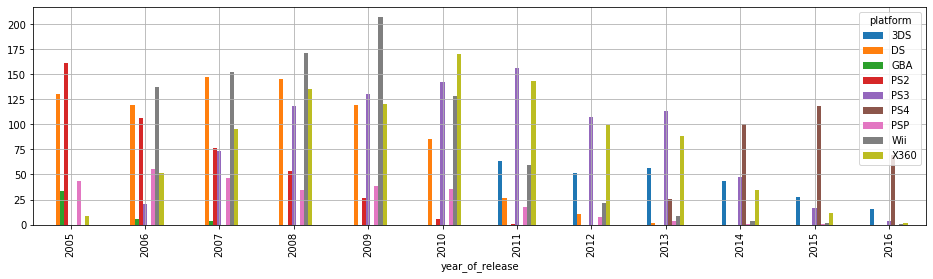

In [14]:
# <Создадим список с наибольшими суммарными продажами по платформам>
platform_list = ['PS2', 'X360', 'PS3','Wii','DS', 'PS', 'PS4', 'GBA', 'PSP' ,'3DS']
# <Создадим сводную таблицу и построим по ней график>
games.query('platform in @platform_list and year_of_release > 2004').pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum').plot(grid=True, kind='bar', figsize=(16, 4))

Найдем топ 5 платформ по продолжительности жизненного цикла

In [15]:
# <Создаем сводную таблицу с мин и макс. годами выхода игр по платформам>
lifetime_of_platforms = games.pivot_table(index = 'platform', values = 'year_of_release', aggfunc = ['min', 'max'])

# <Добавляем столбцем по продолжительности жизненного цикла>
lifetime_of_platforms['lifetime'] = lifetime_of_platforms['max'] - lifetime_of_platforms['min'] + 1

# <Выводим топ 5 платформ по продолжительности>
lifetime_of_platforms.sort_values('lifetime', ascending = False).head(6)

,min,max,lifetime
,year_of_release,year_of_release,
platform,,,
PC,1985,2016,32
DS,1985,2013,29
GB,1988,2001,14
X360,2005,2016,12
PSP,2004,2015,12
PS2,2000,2011,12


Выведем среднее значения жизненного цикла по всем платформам

In [16]:
# <Выводим топ 10 платформ по продолжительности>
lifetime_of_platforms['lifetime'].mean().round(2)

8.61

Однозначно нельзя утверждать, что по последней дате выхода игры жизненный цикл платформы закончился. Возможно на какой-то платформе вышло всего несколько игр за последнии года и платформа по факту перестала поддерживаться раньше. Поэтому далее выберем платформы с наибольшими суммарными продажами и построем распределение по годам с количеством вышедших игр и суммарными продажами.

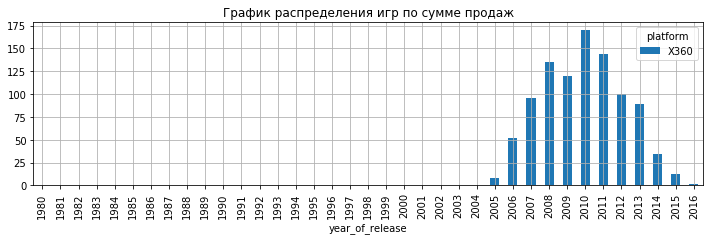

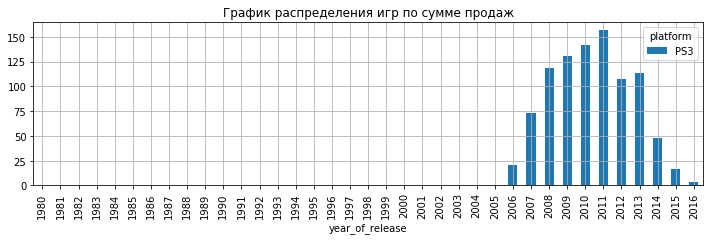

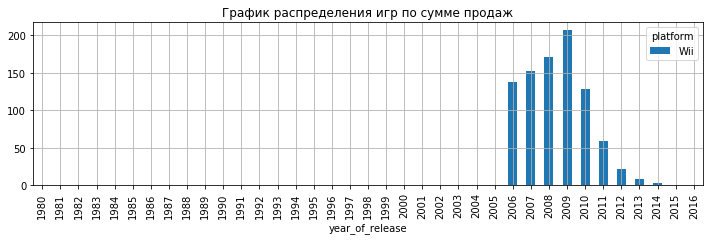

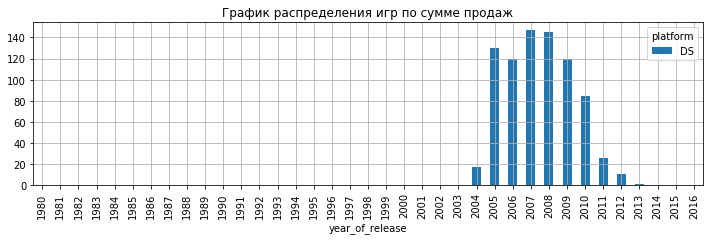

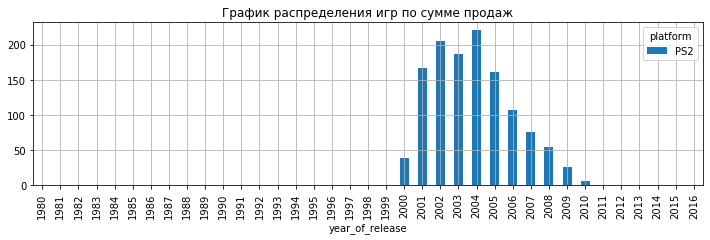

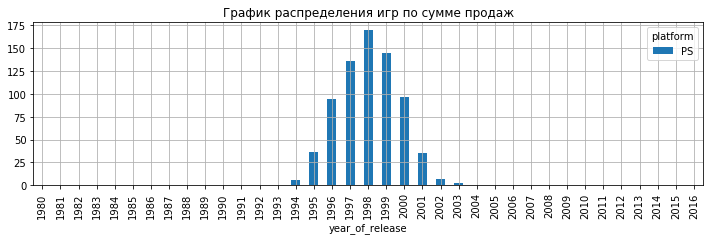

In [17]:
platform_list = ['X360', 'PS3','Wii','DS', 'PS2', 'PS']
games_platform = games.pivot_table(index = 'year_of_release', values='total_sales', columns = 'platform', aggfunc='sum')

for column in platform_list:
    games_platform[[column]].plot(grid=True, kind = 'bar', figsize = (12,3), title='График распределения игр по сумме продаж')

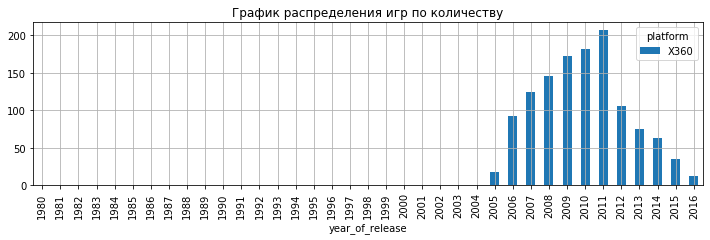

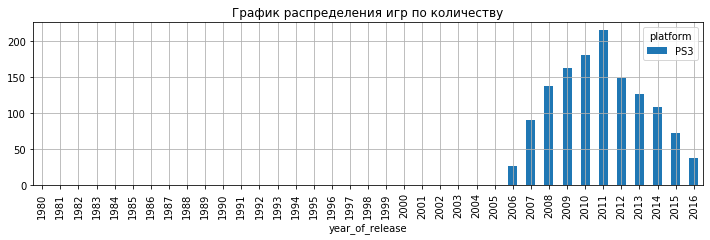

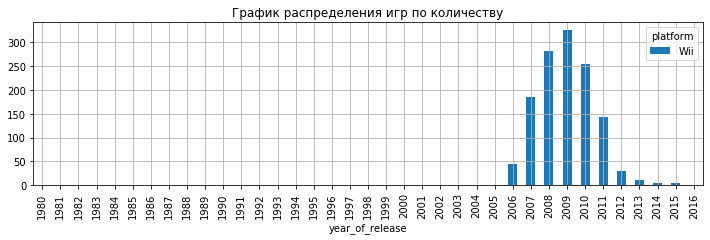

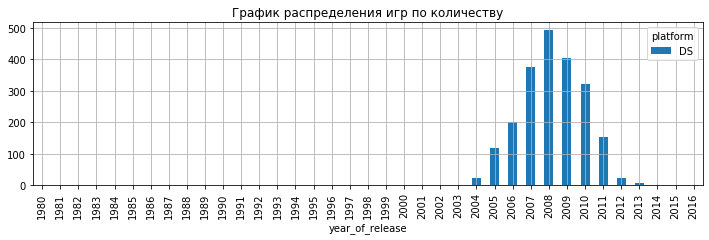

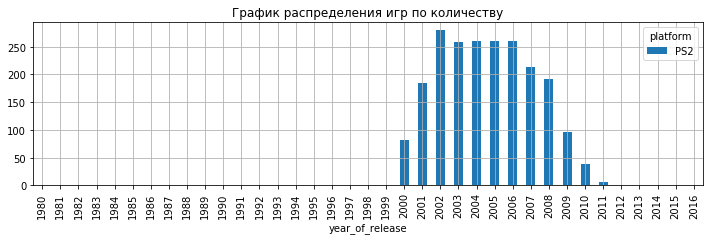

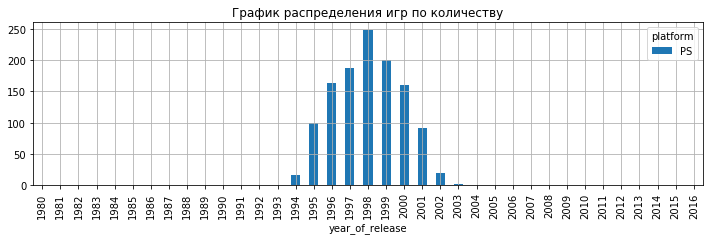

In [18]:
platform_list = ['X360', 'PS3','Wii','DS', 'PS2', 'PS']
games_platform = games.pivot_table(index = 'year_of_release', values='total_sales', columns = 'platform', aggfunc='count')

for column in platform_list:
    games_platform[[column]].plot(grid=True, kind = 'bar', figsize = (12,3), title='График распределения игр по количеству')

### Вывод:

На основе графиков и среднего значения между датами выхода игра на различных платформах можно сделать вывол, что жизненный цикл платформ равен примерно 8 годам. Для построения прогноза на 2017 год примем, что актуальный период начинается с 2013 года. Далее продолжим анализ, начиная с этого года.

Выясним какие платформы лидируют по общей сумме продаж всех игр.

In [19]:
# <Построим таблицу>
actual_games = games.query('year_of_release > 2012')
actual_games.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by = 'total_sales', ascending = False).head()

,total_sales
platform,
PS4,314.14
PS3,181.43
XOne,159.32
3DS,143.25
X360,136.80


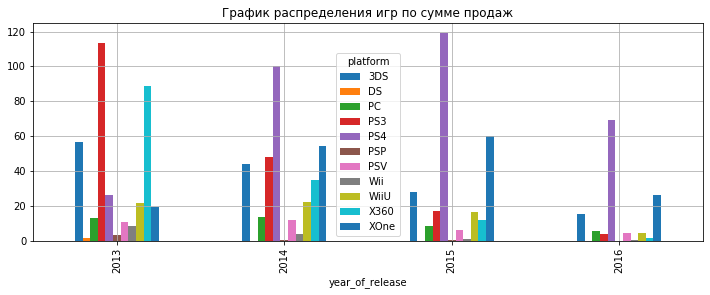

In [20]:
# <Построим график сумм продаж всех игр на платформах по годам>
games_pl = actual_games.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
games_pl.plot(grid=True, kind='bar', figsize=(12, 4), title='График распределения игр по сумме продаж')

### Вывод:

Явный спад продаж наблюдается по платформам X360, PS3, PSP, Wii. Это объясняется тем, что на смену им уже вышли платформы нового поколения. Лидируют по продажам и виден тренд на рост у платформ PS4, XOne. Они являются самымими потенциально прибыльными платформами для выпуска новых игр.

Построим график «ящик с усами» по глобальным продажам игр с разбивкой по 5 потенциально самым прибыльным платформам. 

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



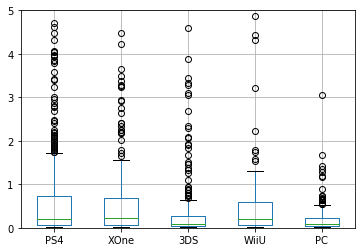

In [21]:
games_bx = actual_games.pivot_table(index='name', columns='platform', values='total_sales', aggfunc='sum')
plt.ylim(0, 5)
boxplot = games_bx.boxplot(column=['PS4','XOne','3DS','WiiU', 'PC'])

Построим таблицу по средним продажам по платформам

In [22]:
actual_games.pivot_table(index='platform', values='total_sales', aggfunc='mean').sort_values(by = 'total_sales', ascending = False).head(7)

,total_sales
platform,
PS4,0.801378
X360,0.735484
XOne,0.645020
Wii,0.593913
WiiU,0.562000
PS3,0.525884
3DS,0.472772


### Вывод:

Три самые выгодне по продажам платформы PS4, XOne и 3DS. На основе графиков можно сделать вывод:
- Общие продажи по всем играм на PS4 выше, чем на XOne и 3DS на 154,82 млн. долларов. и 170,89 млн. долларов. 
- Средние продажи по всем игра на PS4 выше, чем на XOne и 3DS на 0,156 млн. долларов. и 0,329 млн. долларов. 
- По общему количеству игр лидирует платформы PS4, PSV и 3DS. Это объясняется тем, что PS4 самая перспективная платформа для продажи игр, а PSV и 3DS это портативные платформы, на них менее трудозатрано разрабатывать игры. 	

Посмотрим, как влияют на продажи игр на PS4 от отзывов пользователей и критиков.

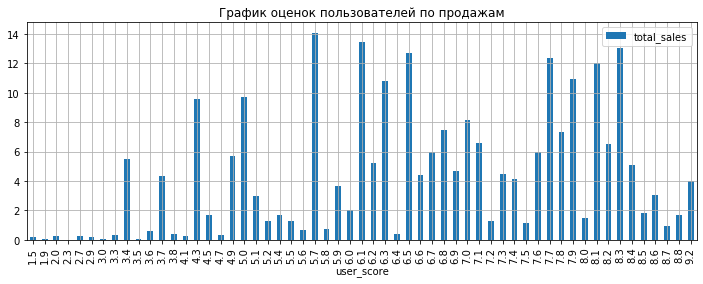

In [23]:
# <Построим график зависимости продаж игр от отзывов пользователей>
actual_games.query('platform in "PS4" and user_score> 0').pivot_table(index='user_score', values='total_sales', aggfunc='sum').plot(grid=True, kind='bar', figsize=(12, 4), title='График оценок пользователей по продажам')

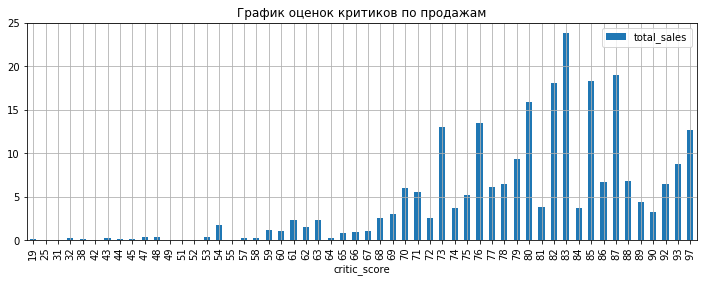

In [24]:
# <Построим график зависимости продаж игр от отзовов критиков>
actual_games.query('platform in "PS4" and critic_score> 0').pivot_table(index='critic_score', values='total_sales', aggfunc='sum').plot(grid=True, kind='bar', figsize=(12, 4), title='График оценок критиков по продажам')

Посчитаем корреляцию между отзывами и продажами

In [25]:
# <Корреляция продаж от рейтинга критиков>
actual_games.query('platform in "PS4" and critic_score> 0')['total_sales'].corr(games['critic_score'])

0.406567902061781

In [26]:
# <Корреляция продаж от рейтинга рейтинга пользователей>
actual_games.query('platform in "PS4" and user_score> 0')['total_sales'].corr(games['user_score'])

-0.031957110204556424

Построим матрицу рассеяния

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0976ef5b90>,
      dtype=object)

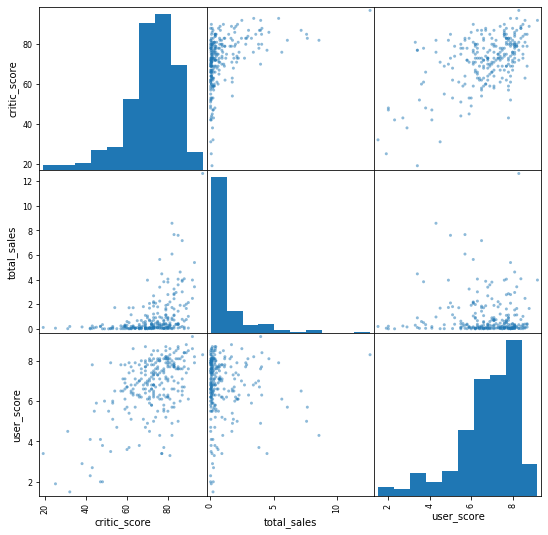

In [27]:
# <Матрица рассеяния>
games_corr = actual_games.query('platform in "PS4" and critic_score> 0 and user_score> 0').pivot_table(index='name', values=['total_sales', 'critic_score', 'user_score'])
pd.plotting.scatter_matrix(games_corr, figsize=(9, 9))

Найдем коэффицент корреляции по всем платформам

In [28]:
# <Корреляция продаж от рейтинга критиков>
actual_games.query('critic_score > 0 and platform != "PS4"')['total_sales'].corr(games['critic_score']).round(3)

0.281

In [29]:
# <Корреляция продаж от рейтинга пользователей>
actual_games.query('user_score> 0 and platform != "PS4"')['total_sales'].corr(games['user_score']).round(3)

-0.001

### Вывод:

По высоким оценкам критиков можно спрогнозировать высокие суммарные продажи игр, т.к. по ним есть прямая связь. От оценок пользователей продажи игр почти ни как не зависят. Коэффицент коррелиции продаж от рейтинга критиков на PS4 больше на 0.12, чем на всех остальных платформах.

Посмотрим на общее распределение игр по жанрам

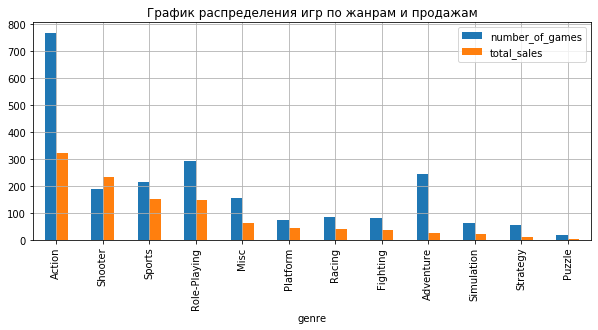

In [30]:
# <Группировка данных по общим продажам и количеству игр>
genre_game = (actual_games
                .groupby(['genre'])
                .agg({'name': 'count', 'total_sales': 'sum'})
                .reset_index(level = 'genre')
                .sort_values('total_sales', ascending = False)
)
genre_game.rename(columns={'name': 'number_of_games'}, inplace=True)
genre_game.plot(title='График распределения игр по жанрам и продажам', x = 'genre', grid=True, figsize=(10, 4), kind='bar')

Визуализируем суммарные продажи игр по жанрам и игровым платформам

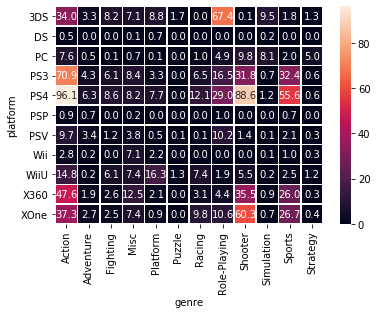

In [31]:
# <Визуализируем суммарные продажи игр по жанрам и игровым платформам>
platform_genre_sales = actual_games.pivot_table(
                        index='platform', 
                        columns='genre', 
                        values='total_sales', 
                        aggfunc=sum).fillna(0).applymap(float)
sns.heatmap(platform_genre_sales, annot=True, fmt=".1f", linewidths=.5)

### Вывод:

- Самые высокие продажи у жанров Action, Shooter и Sports. Жанр Action лидирует, т.к. его часто указывают как не основной жанр у игры.  
- Самые низкие - Simulation, Strategy и Puzzle. Это объясняется тем, что в играх уже продолжительное время идет тренд на упрощение игрового процесса, люди играют чаще в более легкие игры.
- На платформе 3DS самый популарный жанр Role-Playing. Это объясняется тем, что сама платформа разрабатывалась с уклонном для таких игр.

### Шаг 4. Состаление портрета пользователя каждого региона

Построим график продаж видео игр в различных странах в зависимости от года.

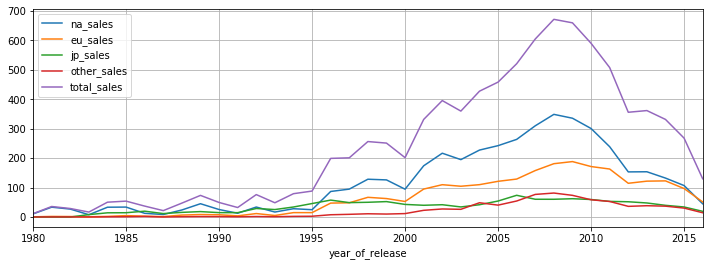

In [32]:
# <Построим график продаж видео игр в различных странах в зависимости от года>
sales_games = games[[x for x in games.columns if 'sales' in x] + ['year_of_release']]
sales_games.groupby('year_of_release').sum().plot(figsize=(12, 4), grid=True)

Определим для пользователя каждого региона:  
1. Самые популярные платформы и жанры.  
3. Влияние рейтинга ESRB на продажи.  

#### 4.1 Самые популярные платформы и жанры

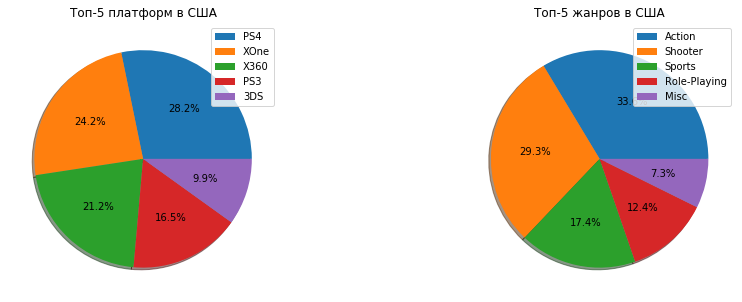

In [33]:
# составим сводную таблицу продаж по регионам с разбивкой на платформы
reg_sales_platform = actual_games.pivot_table(index='platform', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc=sum)
# сводная таблица продаж игр разбивкой на регионы по жанрам
reg_sales_genres = actual_games.pivot_table(index='genre', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc=sum)

# Портрет пользователя для США
# выделим в отдельную таблицу топ-5 платформ для США
na_top5_platforms = reg_sales_platform.sort_values(by='na_sales', ascending=False)['na_sales'].head()
# выделим в отдельную таблицу топ-5 жанров для США
na_genre = reg_sales_genres.sort_values(by='na_sales', ascending=False)['na_sales'].head()
# построим графики по данным в таблицах выше
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5)) # создаем фигрру из 3 элементов
ax1.pie(na_top5_platforms, autopct='%1.1f%%', shadow=True) # строим первый элемент по топ-5 платформ
ax1.set_title('Топ-5 платформ в США') # подписываем график
ax1.legend(na_top5_platforms.index) # обозначаем легенду
ax2.pie(na_genre, autopct='%1.1f%%', shadow=True) # строим второй элемент по топ-5 жанров
ax2.set_title('Топ-5 жанров в США') # подписываем график
ax2.legend(na_genre.index) # обозначаем легенду

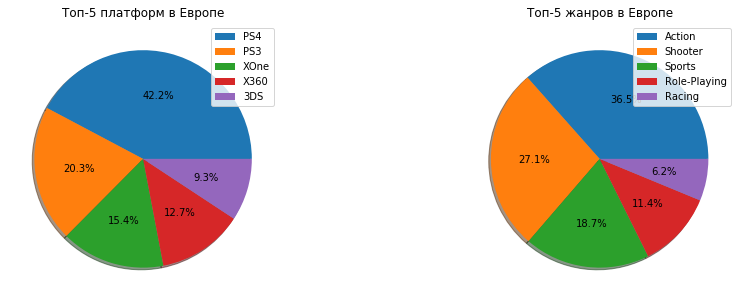

In [34]:
# Портрет пользователя для Европы
# выделим в отдельную таблицу топ-5 платформ для Европы
eu_top5_platforms = reg_sales_platform.sort_values(by='eu_sales', ascending=False)['eu_sales'].head()
# выделим в отдельную таблицу топ-5 жанров для Европы
eu_genre = reg_sales_genres.sort_values(by='eu_sales', ascending=False)['eu_sales'].head()
# построим графики по данным в таблицах выше
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5)) # создаем фигрру из 3 элементов
ax1.pie(eu_top5_platforms, autopct='%1.1f%%', shadow=True) # строим первый элемент по топ-5 платформ
ax1.set_title('Топ-5 платформ в Европе') # подписываем график
ax1.legend(eu_top5_platforms.index) # обозначаем легенду
ax2.pie(eu_genre, autopct='%1.1f%%', shadow=True) # строим второй элемент по топ-5 жанров
ax2.set_title('Топ-5 жанров в Европе') # подписываем график
ax2.legend(eu_genre.index) # обозначаем легенду

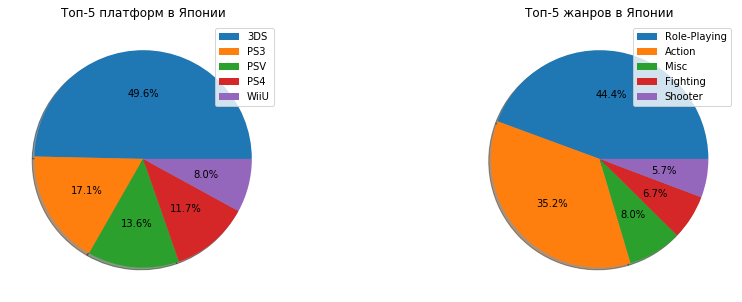

In [35]:
# Портрет пользователя для Японии
# выделим в отдельную таблицу топ-5 платформ для Японии
jp_top5_platforms = reg_sales_platform.sort_values(by='jp_sales', ascending=False)['jp_sales'].head()
# выделим в отдельную таблицу топ-5 жанров для Японии
jp_genre = reg_sales_genres.sort_values(by='jp_sales', ascending=False)['jp_sales'].head()
# построим графики по данным в таблицах выше
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5)) # создаем фигрру из 3 элементов
ax1.pie(jp_top5_platforms, autopct='%1.1f%%', shadow=True) # строим первый элемент по топ-5 платформ
ax1.set_title('Топ-5 платформ в Японии') # подписываем график
ax1.legend(jp_top5_platforms.index) # обозначаем легенду
ax2.pie(jp_genre, autopct='%1.1f%%', shadow=True) # строим второй элемент по топ-5 жанров
ax2.set_title('Топ-5 жанров в Японии') # подписываем график
ax2.legend(jp_genre.index) # обозначаем легенду

#### 4.2 Влияние рейтинга ESRB на продажи.  

ТОП рейтингов в регионе NA за актуальный период
        na_sales  share
rating                 
M         165.27  47.44
E          79.05  22.69
E10+       54.24  15.57
T          49.79  14.29


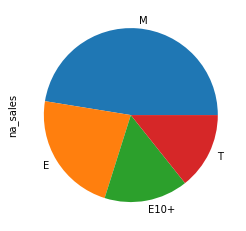

ТОП рейтингов в регионе EU за актуальный период
        eu_sales  share
rating                 
M         145.57  46.42
E          83.36  26.58
E10+       42.69  13.61
T          41.95  13.38


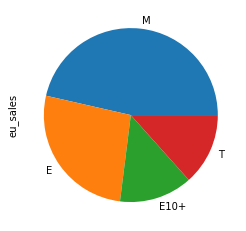

ТОП рейтингов в регионе JP за актуальный период
        jp_sales  share
rating                 
T          20.59  36.95
E          15.14  27.17
M          14.11  25.32
E10+        5.89  10.57


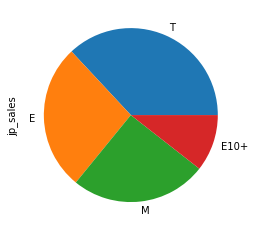

In [36]:
#Топ 5 распределения рейтинга ESRB по регионам
list_3_regions = ['na_sales', 'eu_sales', 'jp_sales']
for column in list_3_regions:
    title = 'ТОП рейтингов в регионе ' + column[:2].upper() + ' за актуальный период'
    print(title)
    table = actual_games.pivot_table(index='rating', values=[column], aggfunc='sum').sort_values(by = column, ascending = False).head(5)
    table['share'] = (table[column] / table[column].sum() * 100).round(2)
    print(table)
    table[column].plot(kind = 'pie', figsize = (4,4))
    plt.show()

### Вывод
- В США самые популярные платформы PS4 и XOne, в Европе PS4 и PS3, в Японии 3DS и PS4 
- В США на почти на первом месте XOne, т.к. разрабатываемые для неё игры больше рассчитаны на западного пользователя.
- Самые популярные жанры совпадают в США и Европе (action, shooter и sport). В Японии местные пользователи очень любят порт портативные role-playing игры, они на первом месте. По этой же причине самая популярная платформа 3DS. 
- Рынки Европы и Америки похожи в отношении топовых рейтингов. Рейтинг М сильно перевешивает даже казалось бы широко покрывающий различные возрасты рейтинг Е
- В Японии игры рейтинга М уступили первенство играм рейтинга T (для подростков)

### Шаг 5. Проверка гипотез

Проверим 2 гипотезы:
- cредние пользовательские рейтинги платформ Xbox One и PC одинаковые
- cредние пользовательские рейтинги жанров Action и Sports разные

#### 4.1 Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Нулевая гипотеза: средние пользовательские рейтинги платформ Xbox One и PC не одинаковые.  
Альтернативная гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

In [37]:
user_score_xone = actual_games.query('platform in "XOne"')['user_score']
user_score_pc =  actual_games.query('platform in "PC"')['user_score']

alpha = .05 # критический уровень статистической значимости, если pvalue окажется меньше него, отвергнем гипотезу.

results = st.ttest_ind(
    user_score_xone, 
    user_score_pc,
    nan_policy ='omit'
)
    
print('p-значение: ', results.pvalue)
    
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.18127251041607714
Не получилось отвергнуть нулевую гипотезу


По проверенной гипотезе можно сделать вывод, средние пользовательские рейтинги платформ Xbox One и PC не совпадают. Вероятность получить одинаковые значения мала.

#### 4.2 Средние пользовательские рейтинги жанров Action и Sports разные

Нулевая гипотеза: cредние пользовательские рейтинги жанров Action и Sports совпадают.  
Альтернативная гипотеза: cредние пользовательские рейтинги жанров Action и Sports разные.

In [38]:
user_score_action = actual_games.query('genre in "Action"')['user_score']
user_score_sports =  actual_games.query('genre in "Sports"')['user_score']

alpha = .05 # критический уровень статистической значимости, если pvalue окажется меньше него, отвергнем гипотезу.

results = st.ttest_ind(
    user_score_action, 
    user_score_sports,
    nan_policy ='omit'
)
    
print('p-значение: ', results.pvalue)
    
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.02341911434092786
Отвергаем нулевую гипотезу


По проверенной гипотезе можно сделать вывод, что средние пользовательские рейтинги жанров Action и Sports разные

Для проверки гипотез использовали двусторонний тест, т.к. в задании вопрос формулировался, как отличаются средние величины и нет разницы в формулировке в задании между гипотезами.

In [39]:
#Средний пользовательский рейтинг платформ Xbox One и PC
actual_games.query('platform in "XOne" or platform in "PC"').pivot_table(index='platform', values='user_score', aggfunc='mean')

,user_score
platform,
PC,4.980526
XOne,4.542105


In [40]:
# Средний пользовательский рейтинг жанров Action и Sports
actual_games.query('genre in "Action" or genre in "Sports"').pivot_table(index='genre', values='user_score', aggfunc='mean')

,user_score
genre,
Action,2.987353
Sports,3.664019


### Вывод

Первая гипотеза не подтвердилась, вторая подтвердилась:
- cредний пользовательский рейтинг на PC, выше чем на Xbox One
- cредний пользовательский рейтинг жанра Sports, выше чем жанра Action 

### Шаг 6. Общий вывод

По проведенному анализу выявленно, что самымими потенциально прибыльными платформами для выпуска новых игр являются PS4, XOne. Так же стоит обратить внимание на 3DS для японского рынка и на Wii и PC . Жизненный цикл платформы примерно равен 8 годам. Все выбранные платформы точно проживут ещё несколько лет.  

При покупке новых игр для продажи стоит обрать внимание:
- на игры с высоким рейтингом критиков, т.к. между ними есть взаимосвязь (коэффицент корреляции 0.28) 
- жанры Action, Shooter, Sports. Отдельно для 3DS стоит обратить внимание на жанр Role-Playing 
- для США самые популярные платформы PS4 и XOne, в Европе PS4 и PS3, в Японии 3DS и PS4 
- на игры с рейтингом ESRB "М" для Европы и Америки и рейтингом "T" для Японии.

Так же в ходе анализа опроверглась теория, что cредний пользовательский рейтинг на PC, выше чем на Xbox One. И подтвердилась теория, что cредний пользовательский рейтинг жанра Sports, выше чем жанра Action. Для проверки гипотез использовали двусторонний тест.